In [15]:
minmaxInterval = 2000

## open port

In [16]:
!echo 'quzinee1!'| sudo -S chmod a+rw /dev/ttyUSB1

[sudo] password for terry: chmod: cannot access '/dev/ttyUSB1': No such file or directory


## BASIC USAGE OF XL320 CLASS

In [17]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from math import pi as PI
DEG90 = PI/2
PROPORTION_MATRIX = np.array(
    [
        [1,0.1,0.4,0.4, 0,0,0,0, 0,0,0,0, 0,0,0,0],
        [0.1,1,0.4,0.4, 0,0,0,0, 0,0,0,0, 0,0,0,0],
        [0.4,0.4,1,0.1, 0,0,0,0, 0,0,0,0, 0,0,0,0],
        [0.4,0.4,0.1,1, 0,0,0,0, 0,0,0,0, 0,0,0,0],
        
        [0,0,0,0,  1,0.1,0.4,0.4, 0,0,0,0, 0,0,0,0],
        [0,0,0,0,  0.1,1,0.4,0.4,  0,0,0,0, 0,0,0,0],
        [0,0,0,0,  0.4,0.4,1,0.1, 0,0,0,0, 0,0,0,0],
        [0,0,0,0,  0.4,0.4,0.1,1, 0,0,0,0, 0,0,0,0],
        
        [0,0,0,0, 0,0,0,0, 1,0.1,0.4,0.4, 0,0,0,0],
        [0,0,0,0, 0,0,0,0, 0.1,1,0.4,0.4, 0,0,0,0],
        [0,0,0,0, 0,0,0,0, 0.4,0.4,1,0.1, 0,0,0,0],
        [0,0,0,0, 0,0,0,0, 0.4,0.4,0.1,1, 0,0,0,0],
        
        [0,0,0,0, 0,0,0,0, 0,0,0,0, 1,0.1,0.4,0.4],
        [0,0,0,0, 0,0,0,0, 0,0,0,0, 0.1,1,0.4,0.4],
        [0,0,0,0, 0,0,0,0, 0,0,0,0, 0.4,0.4,1,0.1],
        [0,0,0,0, 0,0,0,0, 0,0,0,0, 0.4,0.4,0.1,1],
        ])
PROPORTION_MATRIX = PROPORTION_MATRIX[:4,:4]
PROPORTION_MATRIX.shape

(4, 4)

In [18]:
import sys
sys.path.append(".")
""" FOR DYNAMIXEL """
from model.class_xc330 import xc330
""" FOR MODERN DRIVER """
import roslib; roslib.load_manifest('ur_driver')
import rospy
import actionlib
from control_msgs.msg import *
from trajectory_msgs.msg import *
from sensor_msgs.msg import JointState

from class_vicon_marker import VICON
from class_vicon_base import ViconBase

class OneFinger(object):
    def __init__(self,):
        rospy.init_node("DEMO")
        self.JOINT_NAMES = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint',
                            'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
        self.client      = None
        
        self.xc          = xc330('SOFTROBOT', _USB_NUM=0)
        
    def init_xc(self,initpos):
        self.xc.connect()
        self.xc.set_operatingmode([4])

        self.xc.set_torque([0])
        time.sleep(2)
        self.xc.set_torque([1])
        print ("TORQUE ON")

        currpos = self.xc.get_currpos()
        minmaxInterval = 5000
        self.xc.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)

        if initpos is None:
            initpos = currpos; print("No initpos Found")
            self.set_init_pos()
            return currpos

        self.xc.set_goalposcluster(initpos,1)

        print("INITIALIZE POSITION")
        currpos = self.xc.get_currpos()
        print(currpos)

        minmaxInterval = minmaxInterval
        self.xc.set_minmaxpos(currpos-np.ones_like(currpos)*minmaxInterval,currpos+np.ones_like(currpos)*minmaxInterval)
        self.set_init_pos()
        return currpos
        
    def set_init_pos(self):
        self.initpos = self.xc.get_currpos()
    # def move_xc(self,pos):
    #     pos = self.initpos + np.array(pos)* np.array([1,-1,-1,1])
    #     self.xc.set_goalposcluster(pos,1)
        
        
    def move_arm_speed(self, joints, speed):
        try: 
            q = joints
            g = FollowJointTrajectoryGoal()
            g.trajectory = JointTrajectory()
            g.trajectory.joint_names = self.JOINT_NAMES
            joint_states = rospy.wait_for_message("joint_states", JointState)
            joints_pos   = joint_states.position

            diff = np.array(joints_pos) - np.array(q)

            assert speed <= 1e-1 
            movetime = np.linalg.norm(diff)/speed

            g.trajectory.points = [
                JointTrajectoryPoint(positions=joints_pos, velocities=[0]*6, time_from_start=rospy.Duration(0.0)),
                JointTrajectoryPoint(positions=q, velocities=[0]*6, time_from_start=rospy.Duration(movetime))]  

            self.client.send_goal(g)
            self.client.wait_for_result()
        except KeyboardInterrupt:
            self.client.cancel_goal()
            raise
        except:
            raise  
        
    def move_xc(self, control, movetime):
        controls = np.array(control).astype(int)
        assert controls.ndim == 1

        
        pos_list = []
        currpos = self.xc.get_currpos()
        goal_pos  = control * np.array([1,-1,-1,1]) + self.initpos

        resolution = 5
        splitnum = np.linalg.norm(goal_pos - currpos)/resolution

        interpolate_pos = np.linspace(currpos,goal_pos,int(splitnum))
        currpos = goal_pos
        pos_list.append(interpolate_pos)
        
        pos_array = np.vstack(pos_list)

        if len(pos_array) > 0:
            unit_sleep = movetime/len(pos_array)
            for pos in pos_array:
                self.xc.set_goalpos(pos)
                time.sleep(unit_sleep)


    def multiple_move_xc(self, controls, movetimes):
        controls = np.array(controls).astype(int)
        movetimes = np.array(movetimes)
        assert controls.ndim == 2
        assert movetimes.ndim == 1
        
        pos_list = []
        currpos = self.xc.get_currpos()

        for control in controls:
            goal_pos  = control * np.array([1,-1,-1,1]) + self.initpos

            resolution = 5
            splitnum = np.linalg.norm(goal_pos - currpos)/resolution

            interpolate_pos = np.linspace(currpos,goal_pos,int(splitnum))
            currpos = goal_pos
            pos_list.append(interpolate_pos)
            
        # pos_array = np.vstack(pos_list)
        for pos, movetime in zip(pos_list, movetimes):
            unit_sleep = movetime/len(pos)
            for pos_ in pos:
                self.xc.set_goalpos(pos_)
                time.sleep(unit_sleep)

    def execute_arm_speed(self, joints, speed):
        try:
            self.client = actionlib.SimpleActionClient('follow_joint_trajectory', FollowJointTrajectoryAction)
            print("Waiting for server...")
            self.client.wait_for_server()
            print("Connected to server")
            """ Initialize """
            self.move_arm_speed(joints, speed)
            print("Finish plan")

        except KeyboardInterrupt:
            rospy.signal_shutdown("KeyboardInterrupt")
            raise      


## INSTANTIATE Robot 

In [19]:
robot = OneFinger()

[SOFTROBOT] INSTANTIATED AT [b'/dev/ttyUSB0']


In [20]:
init_joint=[0,-DEG90,DEG90,-DEG90,-DEG90, 0]

In [21]:
currpos = robot.init_xc([4722, 3082,  957, 1628])

[SOFTROBOT] CONNECT
[PortHandler setup] The port number 0 has same device name... reinitialize port number 0!!
 SUCCEEDED TO OPEN THE PORT!
 SUCCEEDED TO CHANGE THE BAUDRATE!
COMMUNICATION SUCCESS
[SOFTROBOT] DETECT ID
[SOFTROBOT] [4]MOTORS DETECTED 
[SOFTROBOT] ID_LIST:[[13, 14, 15, 16]]
TORQUE ON
INITIALIZE POSITION
[4673 3105  986 1587]


In [22]:
robot.move_xc([0,0,0,0], movetime=5)

In [23]:
def move_soro(robot:OneFinger, motor_array, time_array):
    motor_array = np.array(motor_array)

    assert motor_array.ndim == 2
    assert len(time_array) == len(motor_array)
    assert (motor_array<=2500).all()
    assert (motor_array>=0).all()

    motor_list = []
    currpos = robot.xc.get_currpos()
    
    for motor_control in motor_array:
        goal_pos  = PROPORTION_MATRIX @ motor_control * np.array([1,-1,-1,1]) + robot.initpos

        resolution = 10
        splitnum = np.linalg.norm(goal_pos - currpos)/resolution

        interpolate_pos = np.linspace(currpos,goal_pos,int(splitnum))
        currpos = goal_pos
        motor_list.append(interpolate_pos)
    
    from tqdm.notebook import tqdm
    for motor_array, movetime in tqdm(zip(motor_list, time_array)):
        
        unit_sleep = movetime/len(motor_array)
        for motor in motor_array:
            robot.xc.set_goalpos(motor)
            time.sleep(unit_sleep* 0.7)
        


In [24]:
motor_array = np.array([[0,0,0,0]]).astype(np.float32)
time_array= np.array([1.0])

move_soro(robot, motor_array, time_array)

0it [00:00, ?it/s]

/tmp/ipykernel_12944/232994809.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  unit_sleep = movetime/len(motor_array)


In [25]:
class Mocap():
    def __init__(self):
        # rospy.init_node("MOCAP")
        self.JOINT_NAMES = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint',
                            'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
        self.client      = None
        self.vicon_marker= VICON()
        # self.vicon_reference  = ViconBase('ReferenceFrame')
        self.vicon_platform = ViconBase('Platform')
        # self.execute_arm(init_joint)
        # self.xc          = xc330('SNAPBOT', _USB_NUM=0)
        
    

In [26]:
import json

mocap = Mocap()

In [27]:
import json

def get_mocap_info(mocap:Mocap):
    integrated_dict = {}

    platform_data_ = mocap.vicon_platform.transform_data
    platform_dict_ = dict(
        plat_x=platform_data_.position.x,
        plat_y=platform_data_.position.y,
        plat_z=platform_data_.position.z)
    integrated_dict.update(platform_dict_)
    

    markers = mocap.vicon_marker.markers
    assert len(markers) == 1
    marker = markers[0]
    EE_dict_ = dict(
        EE_x = marker.position.x,
        EE_y = marker.position.y,
        EE_z = marker.position.z
    )

    integrated_dict.update(EE_dict_)
    
    return integrated_dict

mocap_info = get_mocap_info(mocap)

In [28]:
p_plat = np.array([mocap_info['plat_x'], mocap_info['plat_y'], mocap_info['plat_z']])
p_ee = np.array([mocap_info['EE_x'], mocap_info['EE_y'], mocap_info['EE_z']])

p_zero = p_ee-p_plat
p_zero

array([-0.00720674,  0.12697262,  0.00310135])

In [29]:
def get_random_motor_control(limit=2000):
    r = np.random.rand(1).astype(np.float32) * limit
    theta = np.random.rand(1).astype(np.float32) * 2 * np.pi

    motor_control = np.array([r*np.cos(theta), r*np.sin(theta)]).astype(np.float32)

    return motor_control

def motor_control_to_motor_array(motor_control):
    motor_array = np.zeros(4).astype(np.float32)

    # motor_array[1] = motor_control[0]
    # motor_array[2] = motor_control[1]

    if motor_control[0] > 0:
        motor_array[0] = motor_control[0]
    else:
        motor_array[1] = -motor_control[0]

    if motor_control[1] > 0:
        motor_array[2] = motor_control[1]
    else:
        motor_array[3] = -motor_control[1]

    motor_array = motor_array.reshape(1,-1) 
    
    return motor_array


motor_control = get_random_motor_control(limit=2000)
motor_control_to_motor_array(motor_control), motor_control

(array([[1667.669  ,    0.     ,    0.     ,  350.17438]], dtype=float32),
 array([[1667.669  ],
        [-350.17438]], dtype=float32))

# Path Trajectory

In [39]:
for key in data:
    print(key)

actuation
target_trajectory


In [40]:
from pathlib import Path
path = Path("planned_traj/small_square1")

data = np.load(path/'PRIMNET.npz')
planed_motor_array = data['actuation']
target_trajectory = data['target_trajectory']
planed_motor_array.shape, np.max(planed_motor_array), planed_motor_array

((10, 1, 2),
 816.004638671875,
 array([[[ -29.7154007 ,  -70.8663559 ]],
 
        [[-702.38525391,  415.53665161]],
 
        [[-702.56463623,  416.43783569]],
 
        [[-556.24957275, -841.25195312]],
 
        [[-556.18786621, -841.3260498 ]],
 
        [[ 816.00463867, -665.19042969]],
 
        [[ 815.90283203, -665.13781738]],
 
        [[ 630.69732666,  541.91827393]],
 
        [[ 623.58111572,  542.83813477]],
 
        [[-702.5604248 ,  418.08724976]]]))

In [48]:
mocap_info_list = []
for motor_control in planed_motor_array:
    motor_control = motor_control[0]
    time_array= np.array([0.5])
    motor_array = motor_control_to_motor_array(motor_control)
    move_soro(robot, motor_array, time_array)
    time.sleep(0.5)
    mocap_info = get_mocap_info(mocap)
    mocap_info_list.append(mocap_info)

    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [53]:
position_list = []

transform_matrix = np.array(
    [
        [ 0,-1, 0],
        [ 0, 0, 1],
        [-1, 0, 0]
    ]
)


for mocap_info in mocap_info_list:
    
    p_plat = np.array([mocap_info['plat_x'], mocap_info['plat_y'], mocap_info['plat_z']])
    p_ee = np.array([mocap_info['EE_x'], mocap_info['EE_y'], mocap_info['EE_z']])
    p_off = np.array([p_zero[0], 0, p_zero[2]])

    position_ = p_ee-p_plat -p_off
    position_ = (position_ @ transform_matrix)
    position_list.append(position_)

position_array = np.array(position_list)
position_array.shape




(10, 3)

In [54]:
pos_off = target_trajectory[0] - position_array[0]

pos_off = np.array([0,0,0])

(-0.05, 0.05)

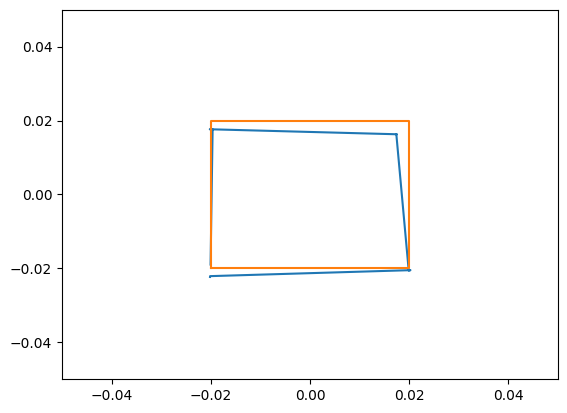

In [56]:
from matplotlib import pyplot as plt

plt.plot(position_array[1:,0]+pos_off[0], position_array[1:,1]+pos_off[1])

target_trajectory = data['target_trajectory']
plt.plot(target_trajectory[1:,0], target_trajectory[1:,1])

plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)

In [57]:
data = dict(data)
data['result'] = position_array
np.savez(path/'PRIMNET_res.npz', **data)

(-0.05, 0.05)

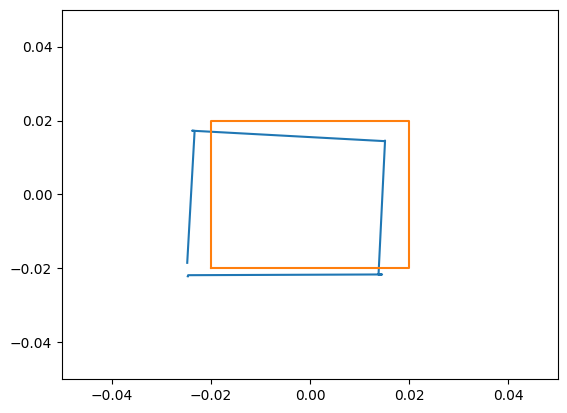

shutdown request: [/DEMO] Reason: new node registered with same name


In [117]:
path = Path("planned_traj/small_square3")

data = np.load(path/'PRIMNET.npz')

plt.plot(data['result'][1:,0], data['result'][1:,1])
plt.plot(data['target_trajectory'][1:,0], data['target_trajectory'][1:,1])

plt.xlim(-0.05, 0.05)
plt.ylim(-0.05, 0.05)
